### DFT validation of top predictions

In [2]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='talk',
    # context='paper',
    # font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [3]:
print(np.__version__)
print(pd.__version__)

1.22.3
1.4.2


In [4]:
os.chdir('../')

In [5]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule
from rlmolecule.sql.run_config import RunConfig
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore
from scripts import ehull

/home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_energy


In [65]:
# out_dir = "/projects/rlmolecule/jlaw/crystals/2022-01-25/"
# dft_decomp_energies_file = f"{out_dir}/mctsvalidation_Mg80decor_1.csv"
out_dir = "//projects/rlmolecule/jlaw/crystal_outputs/2022-05-04"
# best_decorations.csv
viz_dir = f"{out_dir}/batt-icsd-volpred-KLiNa-no-halides-ScY/viz"
os.makedirs(viz_dir, exist_ok=True)
# dft_relax_energies = "/projects/rlmolecule/pgorai/mcts_validation_04282022/mcts_validation_04282022.csv"
dft_data = pd.DataFrame()
for dft_relax_file in [
    # "mcts_validation_q3_redone1.csv",
    # "mcts_validation_q3_redone2.csv",
    # "mcts_validation_q2_redone.csv",
    "mcts_validation_05212022.csv",
]:
    dft_relax_energies = f"/projects/rlmolecule/pgorai/mcts_validation_05212022/{dft_relax_file}"
    # df = pd.read_csv(dft_decomp_energies_file, index_col=0, names=['energyperatom', 'decomp_energy'])
    print(f"Reading {dft_relax_energies}")
    curr_dft_data = pd.read_csv(dft_relax_energies)
    print(f"\t{len(curr_dft_data)}")
    dft_data = pd.concat([dft_data, curr_dft_data])
dft_data.head(2)

Reading /projects/rlmolecule/pgorai/mcts_validation_05212022/mcts_validation_05212022.csv
	381


,decoration,numatoms,relaxedvolume,energyperatom
0,K1Sb1F6/K1Sb1F6_sg148_icsd_015343_1,8,132.81,-4.636
1,Na1Hf1Hg1I7/Na1Hf1Hg1I7_sg9_icsd_060952_2,40,2016.09,-2.820


### Compute the decomposition energy for each of them

In [6]:
# Dataframe containing competing phases from NRELMatDB
print("Reading inputs/competing_phases.csv")
df_competing_phases = pd.read_csv('inputs/competing_phases.csv')
print(f"\t{len(df_competing_phases)} lines")
print(df_competing_phases.head(2))

Reading inputs/competing_phases.csv
	12682 lines
  sortedformula   icsdnum  energyperatom reduced_composition
0    Ag10Br3Te4  173116.0      -1.718985          Ag10Br3Te4
1   Ag11K1O16V4  391344.0      -4.797702         Ag11K1O16V4


In [67]:
dft_data['comp'] = dft_data.decoration.apply(lambda x: x.split('/')[0])
dft_data['id'] = dft_data.decoration.apply(lambda x: x.split('/')[1])
dft_data.head(2)

,decoration,numatoms,relaxedvolume,energyperatom,comp,id
0,K1Sb1F6/K1Sb1F6_sg148_icsd_015343_1,8,132.81,-4.636,K1Sb1F6,K1Sb1F6_sg148_icsd_015343_1
1,Na1Hf1Hg1I7/Na1Hf1Hg1I7_sg9_icsd_060952_2,40,2016.09,-2.820,Na1Hf1Hg1I7,Na1Hf1Hg1I7_sg9_icsd_060952_2


In [15]:
def compute_decomp_energy(row, energy_col="energyperatom"):
    comp, energyperatom = row.comp, row[energy_col]
    decomp_energy = ehull.convex_hull_stability(comp,
                                                energyperatom,
                                                df_competing_phases)

    return decomp_energy

In [68]:
dft_data['decomp_energy'] = dft_data.progress_apply(compute_decomp_energy, axis=1)

  0%|          | 0/381 [00:00<?, ?it/s]

In [69]:
print(len(dft_data[dft_data['decomp_energy'] < -1]))
print(len(dft_data[dft_data['decomp_energy'] < 0]))
print(len(dft_data[dft_data['decomp_energy'] < 0.05]))

7
222
279


In [11]:
run_id = "batt-icsd-volpred-KLiNa-no-halides-ScY"
# run_id = "volpred-KLiNa"
# run_id = "2022-05-09-batt-icsd-cos-dist-Li"
pred_file = f"{out_dir}/{run_id}/best_decorations.p"
viz_dir = f"{out_dir}/{run_id}/viz"
os.makedirs(viz_dir, exist_ok=True)
df_pred = pd.read_pickle(pred_file)
df_pred.head(2)

,decor_id,reward,pred_decomp_energy,pred_energyperatom,comp,id,structure,dls_volume
409,K1Al1Br4|_1_1_4|orthorhombic|sg33_icsd_404394|1,0.907,-0.907,-3.266222,K1Al1Br4,K1Al1Br4_sg33_icsd_404394_1,"[[7.33708713 8.58120866 1.77059988] Al, [5.957...",1154.463218
1820,K1Al1Cl4|_1_1_4|orthorhombic|sg21_icsd_079527|1,0.099,-0.099,-3.792170,K1Al1Cl4,K1Al1Cl4_sg21_icsd_079527_1,[[2.73436021e-16 2.73436021e-16 4.46554911e+00...,1509.532585


In [62]:
from scripts import stability
from importlib import reload
reload(ehull)
reload(stability)


<module 'scripts.stability' from '/home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_energy/scripts/stability.py'>

In [70]:
# now make a scatterplot
# df2 = df_pred.reset_index()[['id', 'pred_energyperatom', 'pred_decomp_energy']]
df2 = df_pred.reset_index()[['id', 'pred_energyperatom', 'pred_decomp_energy3']]
df = pd.merge(dft_data, df2, on='id', how='inner')
# df = df[df['pred_decomp_energy'] <= -0.01]
print(len(df[df.decomp_energy < 0]), len(df))
df.head(2)

222 381


,decoration,numatoms,relaxedvolume,energyperatom,comp,id,decomp_energy,pred_energyperatom,pred_decomp_energy3
0,K1Sb1F6/K1Sb1F6_sg148_icsd_015343_1,8,132.81,-4.636,K1Sb1F6,K1Sb1F6_sg148_icsd_015343_1,0.00926,-4.608471,0.036789
1,Na1Hf1Hg1I7/Na1Hf1Hg1I7_sg9_icsd_060952_2,40,2016.09,-2.820,Na1Hf1Hg1I7,Na1Hf1Hg1I7_sg9_icsd_060952_2,0.04500,-2.620724,0.244000


In [6]:
# load the results from a previous run
viz_dir = "/projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/batt-icsd-volpred-KLiNa-no-halides-ScY/viz"
df = pd.read_csv(f"{viz_dir}/pred_vs_dft_corrected.csv", index_col=0)
print(len(df[df.decomp_energy < 0]), len(df))
df.head(2)

222 381


,decoration,numatoms,relaxedvolume,energyperatom,comp,id,decomp_energy,pred_energyperatom,pred_decomp_energy
0,K1Sb1F6/K1Sb1F6_sg148_icsd_015343_1,8,132.81,-4.636,K1Sb1F6,K1Sb1F6_sg148_icsd_015343_1,0.00926,-4.608471,0.036789
1,Na1Hf1Hg1I7/Na1Hf1Hg1I7_sg9_icsd_060952_2,40,2016.09,-2.820,Na1Hf1Hg1I7,Na1Hf1Hg1I7_sg9_icsd_060952_2,0.04500,-2.620724,0.244000


In [8]:
# load the results from a previous run
viz_dir = "/projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/batt-icsd-volpred-KLiNa/viz"
df2 = pd.read_csv(f"{viz_dir}/pred_vs_dft.csv", index_col=0)
print(len(df2[df2.decomp_energy < 0]), len(df2))
df2.head(2)

36 36


,decoration,numatoms,relaxedvolume,energyperatom,comp,id,decomp_energy,pred_energyperatom,pred_decomp_energy
0,relaxed_2/Na1Sc1Y1Br7/Na1Sc1Y1Br7_sg14_icsd_02...,40,1437.78,-4.073,Na1Sc1Y1Br7,Na1Sc1Y1Br7_sg14_icsd_024423_1,-1.319,-4.004704,-1.251
1,relaxed_2/K1Sc2I7/K1Sc2I7_sg13_icsd_067168_1,20,880.73,-3.492,K1Sc2I7,K1Sc2I7_sg13_icsd_067168_1,-1.129,-3.398715,-1.037


In [9]:
df = pd.concat([df, df2])

In [12]:
df = df[df.pred_decomp_energy < 0]
print(len(df))

267


In [13]:
print(len(df[df.decomp_energy < 0]))

244


In [72]:
out_file = f"{viz_dir}/pred_vs_dft_corrected.csv"
print(out_file)
df.to_csv(out_file)

//projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/pred_vs_dft_corrected.csv


<AxesSubplot:>

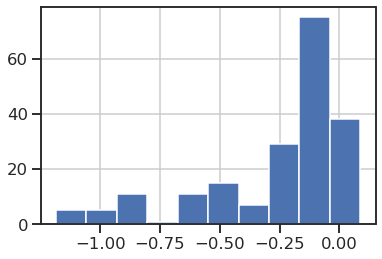

In [35]:
df.decomp_energy.hist()

/projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/batt-icsd-volpred-KLiNa/viz/pred_vs_dft_decomp_energy_combined.svg


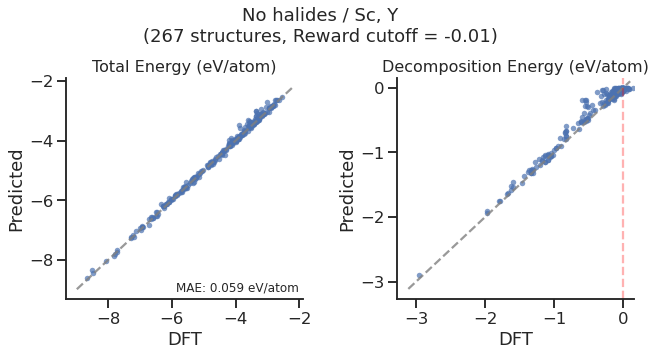

In [15]:
f, (ax2, ax1) = plt.subplots(ncols=2, figsize=(9,5))

# ax1 = sns.scatterplot(data=df, ax=ax1,
ax1 = df.plot.scatter(ax=ax1,
                x='decomp_energy', y='pred_decomp_energy', 
                alpha=0.7, s=30, linewidth=0,
)
# ax1.plot([-1,0], [-1,0], ls='--', c='gray')
ax1.plot((ax1.get_xlim()[0], 0.1), 
         (ax1.get_xlim()[0], 0.1), 
         ls='--', c='gray', alpha=0.8)
ax1.set_ylim(ymin=ax1.get_ylim()[0], ymax=0.15)
ax1.set_xlim(xmin=ax1.get_xlim()[0], xmax=0.15)
ax1.axvline(0, ls='--', c='red', alpha=0.3)
ax1.set_xlabel("DFT")
ax1.set_ylabel("Predicted")
ax1.set_title("Decomposition Energy (eV/atom)", fontsize=16)

df.plot.scatter(x="energyperatom", y="pred_energyperatom", ax=ax2,
                alpha=0.7, s=30, linewidth=0,
               )
# ax2.plot([-8,-3], [-8,-3], ls='--', c='gray')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), ls='--', c='gray', alpha=0.8)
ax2.set_xlabel("DFT")
ax2.set_ylabel("Predicted")
ax2.set_title("Total Energy (eV/atom)", fontsize=16)
mae = (df['energyperatom'] - df["pred_energyperatom"]).abs().mean()
ax2.text(1, 0.025, f'MAE: {mae:.3f} eV/atom ',
        ha='right', va='bottom', transform=ax2.transAxes, fontsize=12)

# plt.suptitle(f"MCTS run ({len(df)} strcs):\n"
# plt.suptitle(f"MCTS run no halides and no Sc, Y ({len(df)} strcs):\n"
             # f"ICSD, Battery Relaxed, & Volume Relaxed")
# plt.suptitle(f"Unconstrained\n({len(df)} structures, Reward cutoff = -1)", fontsize=18)
plt.suptitle(f"No halides / Sc, Y\n({len(df)} structures, Reward cutoff = -0.01)", fontsize=18)

sns.despine()
plt.tight_layout()
out_file = f"{viz_dir}/pred_vs_dft_decomp_energy_combined.svg"
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
# plt.savefig(out_file.replace('.svg','.png'), bbox_inches='tight', dpi=300)

//projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/pred_vs_dft_decomp_energy.svg


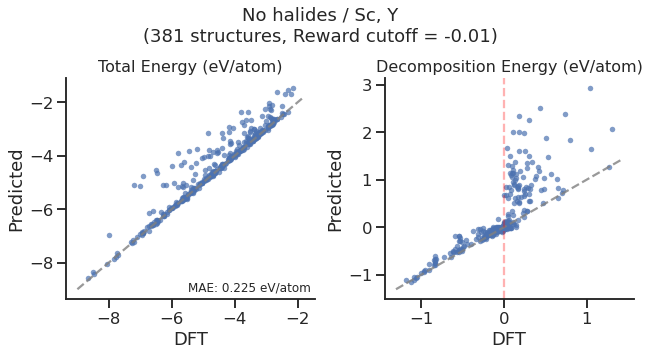

In [74]:
f, (ax2, ax1) = plt.subplots(ncols=2, figsize=(9,5))

# ax1 = sns.scatterplot(data=df, ax=ax1,
ax1 = df.plot.scatter(ax=ax1,
                x='decomp_energy', y='pred_decomp_energy', 
                alpha=0.7, s=30, linewidth=0,
)
# ax1.plot([-1,0], [-1,0], ls='--', c='gray')
ax1.plot((ax1.get_xlim()), 
         (ax1.get_xlim()), 
         ls='--', c='gray', alpha=0.8)
# ax1.set_ylim(ymin=ax1.get_ylim()[0], ymax=0.15)
# ax1.set_xlim(xmin=ax1.get_xlim()[0], xmax=0.15)
ax1.axvline(0, ls='--', c='red', alpha=0.3)
ax1.set_xlabel("DFT")
ax1.set_ylabel("Predicted")
ax1.set_title("Decomposition Energy (eV/atom)", fontsize=16)

df.plot.scatter(x="energyperatom", y="pred_energyperatom", ax=ax2,
                alpha=0.7, s=30, linewidth=0,
               )
# ax2.plot([-8,-3], [-8,-3], ls='--', c='gray')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), ls='--', c='gray', alpha=0.8)
ax2.set_xlabel("DFT")
ax2.set_ylabel("Predicted")
ax2.set_title("Total Energy (eV/atom)", fontsize=16)
mae = (df['energyperatom'] - df["pred_energyperatom"]).abs().mean()
ax2.text(1, 0.025, f'MAE: {mae:.3f} eV/atom ',
        ha='right', va='bottom', transform=ax2.transAxes, fontsize=12)

# plt.suptitle(f"MCTS run ({len(df)} strcs):\n"
# plt.suptitle(f"MCTS run no halides and no Sc, Y ({len(df)} strcs):\n"
             # f"ICSD, Battery Relaxed, & Volume Relaxed")
# plt.suptitle(f"Unconstrained\n({len(df)} structures, Reward cutoff = -1)", fontsize=18)
plt.suptitle(f"No halides / Sc, Y\n({len(df)} structures, Reward cutoff = -0.01)", fontsize=18)

sns.despine()
plt.tight_layout()
out_file = f"{viz_dir}/pred_vs_dft_decomp_energy.svg"
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.svg','.png'), bbox_inches='tight', dpi=300)

In [8]:
dft_data['comp'] = dft_data.decoration.apply(lambda x: x.split('/')[0])
dft_data['id'] = dft_data.decoration.apply(lambda x: x.split('/')[1])
dft_data.head(2)

,decoration,numatoms,relaxedvolume,energyperatom,comp,id
0,K1Sb1F6/K1Sb1F6_sg148_icsd_015343_1,8,132.81,-4.636,K1Sb1F6,K1Sb1F6_sg148_icsd_015343_1
1,Na1Hf1Hg1I7/Na1Hf1Hg1I7_sg9_icsd_060952_2,40,2016.09,-2.820,Na1Hf1Hg1I7,Na1Hf1Hg1I7_sg9_icsd_060952_2


In [24]:
competing_phase_comps = df_competing_phases.reduced_composition.values
print(competing_phase_comps[:10])

['Ag10Br3Te4' 'Ag11K1O16V4' 'Ag15Cl3P4S16' 'Ag16Ca6N1' 'Ag1Al1Li2'
 'Ag1Al1O2' 'Ag1Al1S2' 'Ag1Al1Se2' 'Ag1Al1Te2' 'Ag1As1Ba1']


In [27]:
df['comp'] = df.id.apply(lambda x: x.split('_')[0])
df['sorted_comp'] = df.comp.apply(ehull.sort_comp).apply(lambda x: x[0])
df['in_icsd'] = df.sorted_comp.apply(lambda x: x in competing_phase_comps)
df.head(2)

,id,energyperatom,decomp_energy,pred_energyperatom,pred_decomp_energy2,comp,sorted_comp,in_icsd
0,K1Sb1F6_sg148_icsd_015343_1,-4.636,0.00926,-4.608471,0.036789,K1Sb1F6,F6K1Sb1,True
1,Na1Hf1Hg1I7_sg9_icsd_060952_2,-2.820,0.04500,-2.620724,-0.001000,Na1Hf1Hg1I7,Hf1Hg1I7Na1,False


In [28]:
df[df.decomp_energy > 0]

,id,energyperatom,decomp_energy,pred_energyperatom,pred_decomp_energy2,comp,sorted_comp,in_icsd
0,K1Sb1F6_sg148_icsd_015343_1,-4.636,0.009260,-4.608471,0.036789,K1Sb1F6,F6K1Sb1,True
1,Na1Hf1Hg1I7_sg9_icsd_060952_2,-2.820,0.045000,-2.620724,-0.001000,Na1Hf1Hg1I7,Hf1Hg1I7Na1,False
7,Li1Hg2F5_sg15_icsd_202394_1,-3.256,0.037000,-3.300920,-0.011000,Li1Hg2F5,F5Hg2Li1,False
8,Na1Sc1Sn2S6_sg12_icsd_154011_1,-4.642,0.183000,-4.324407,-0.001000,Na1Sc1Sn2S6,Na1S6Sc1Sn2,False
9,Na4Cl2O1_sg56_icsd_150383_1,-3.538,0.009000,-3.551382,-0.005000,Na4Cl2O1,Cl2Na4O1,False
...,...,...,...,...,...,...,...,...
356,Na2Zn2F3Cl3_sg139_icsd_054042_1,-2.297,1.307000,-1.546151,-0.001000,Na2Zn2F3Cl3,Cl3F3Na2Zn2,False
366,Na1Y1Ti2O6_sg137_icsd_079353_2,-7.821,0.019000,-7.854198,-0.015000,Na1Y1Ti2O6,Na1O6Ti2Y1,False
368,Li2Cd3O4_sg164_icsd_095471_1,-4.187,0.051000,-2.919909,-0.001000,Li2Cd3O4,Cd3Li2O4,False
369,Li1Sc2Ge2P5_sg62_icsd_097426_2,-5.265,0.267000,-4.694785,-0.001000,Li1Sc2Ge2P5,Ge2Li1P5Sc2,False


In [30]:
df[~df.in_icsd][df.decomp_energy > 0]

/tmp/ipykernel_32925/2211463647.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[~df.in_icsd][df.decomp_energy > 0]


,id,energyperatom,decomp_energy,pred_energyperatom,pred_decomp_energy2,comp,sorted_comp,in_icsd
1,Na1Hf1Hg1I7_sg9_icsd_060952_2,-2.820,0.045,-2.620724,-0.001,Na1Hf1Hg1I7,Hf1Hg1I7Na1,False
7,Li1Hg2F5_sg15_icsd_202394_1,-3.256,0.037,-3.300920,-0.011,Li1Hg2F5,F5Hg2Li1,False
8,Na1Sc1Sn2S6_sg12_icsd_154011_1,-4.642,0.183,-4.324407,-0.001,Na1Sc1Sn2S6,Na1S6Sc1Sn2,False
9,Na4Cl2O1_sg56_icsd_150383_1,-3.538,0.009,-3.551382,-0.005,Na4Cl2O1,Cl2Na4O1,False
21,Na1Al1Ge2S6_sg12_icsd_154011_1,-4.558,0.021,-3.902841,-0.001,Na1Al1Ge2S6,Al1Ge2Na1S6,False
...,...,...,...,...,...,...,...,...
352,Li1Al1Sn2S6_sg225_icsd_027345_1,-3.932,0.333,-3.764590,-0.001,Li1Al1Sn2S6,Al1Li1S6Sn2,False
356,Na2Zn2F3Cl3_sg139_icsd_054042_1,-2.297,1.307,-1.546151,-0.001,Na2Zn2F3Cl3,Cl3F3Na2Zn2,False
366,Na1Y1Ti2O6_sg137_icsd_079353_2,-7.821,0.019,-7.854198,-0.015,Na1Y1Ti2O6,Na1O6Ti2Y1,False
368,Li2Cd3O4_sg164_icsd_095471_1,-4.187,0.051,-2.919909,-0.001,Li2Cd3O4,Cd3Li2O4,False


In [85]:
sns.set_context('talk')

/projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/batt-icsd-volpred-KLiNa/viz/pred_vs_dft_decomp_energy_combined2.svg


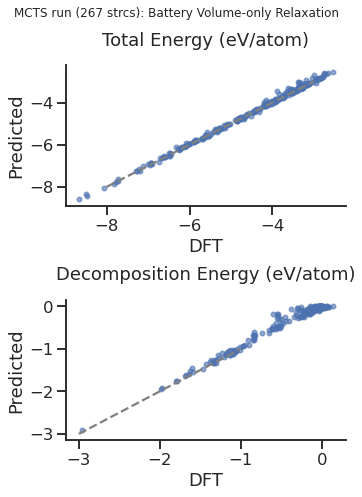

In [18]:
f, (ax2, ax1) = plt.subplots(nrows=2, figsize=(5,7))

ax = ax1
# ax1 = sns.scatterplot(data=df, ax=ax1,
df.plot.scatter(ax=ax,
                x='decomp_energy', y='pred_decomp_energy', 
                alpha=0.6,
)
ax.plot([-3,-1], [-3,-1], ls='--', c='gray')
ax.set_xlabel("DFT")
ax.set_ylabel("Predicted")
ax.set_title("Decomposition Energy (eV/atom)", pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_yticks(ax.get_xticks()[1:-1])

ax = ax2
df.plot.scatter(x="energyperatom", y="pred_energyperatom", ax=ax,
                alpha=0.6,
               )
ax.plot([-8,-3], [-8,-3], ls='--', c='gray')
ax.set_xlabel("DFT")
ax.set_ylabel("Predicted")
ax.set_title("Total Energy (eV/atom)", pad=20)
ax.set_yticks(ax.get_xticks()[1:-1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.suptitle(f"MCTS run ({len(df)} strcs): Battery Volume-only Relaxation")
plt.tight_layout()
out_file = f"{viz_dir}/pred_vs_dft_decomp_energy_combined2.svg"
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
# plt.savefig(out_file.replace('.svg','.png'), bbox_inches='tight', dpi=300)

In [100]:
(df.energyperatom - df.pred_energyperatom).abs().mean()

0.05459728797276821

In [27]:
df['ediff'] = (df.energyperatom - df.pred_energyperatom)
df.sort_values('ediff', ascending=False).head(5)

,decoration,numatoms,relaxedvolume,energyperatom,comp,id,decomp_energy,pred_energyperatom,pred_decomp_energy,ediff
42,Na4Cl1N1/Na4Cl1N1_sg191_icsd_044215_1,12,350.91,-2.140,Na4Cl1N1,Na4Cl1N1_sg191_icsd_044215_1,0.911,-8.324104,-5.275,6.184104
262,Na5Cl2N1/Na5Cl2N1_sg65_icsd_160916_1,16,458.66,-2.337,Na5Cl2N1,Na5Cl2N1_sg65_icsd_160916_1,0.043,-8.028287,-4.895,5.691287
5,Na1Hg1Ge1F1Cl6/Na1Hg1Ge1F1Cl6_sg216_icsd_03960...,40,1018.79,-2.479,Na1Hg1Ge1F1Cl6,Na1Hg1Ge1F1Cl6_sg216_icsd_039604_21,0.653,-7.913330,-4.783,5.434330
8,Na4Cd1N2/Na4Cd1N2_sg64_icsd_047130_1,28,543.24,-2.484,Na4Cd1N2,Na4Cd1N2_sg64_icsd_047130_1,0.609,-7.699223,-4.609,5.215223
499,Na5O1N1/Na5O1N1_sg194_icsd_646285_1,28,584.06,-3.156,Na5O1N1,Na5O1N1_sg194_icsd_646285_1,0.099,-8.355966,-5.103,5.199966


In [29]:
df.sort_values('decomp_energy').head(30)

,decoration,numatoms,relaxedvolume,energyperatom,comp,id,decomp_energy,pred_energyperatom,pred_decomp_energy,ediff
138,Li1Sc1F4/Li1Sc1F4_sg129_icsd_152951_1,12,179.60,-6.036,Li1Sc1F4,Li1Sc1F4_sg129_icsd_152951_1,-1.969,-6.578149,-2.511,0.542149
339,Na1Sc1F4/Na1Sc1F4_sg65_icsd_016492_2,12,144.68,-5.872,Na1Sc1F4,Na1Sc1F4_sg65_icsd_016492_2,-1.953,-7.542525,-3.625,1.670525
401,Na3Sc1F6/Na3Sc1F6_sg182_icsd_076073_1,20,294.55,-5.260,Na3Sc1F6,Na3Sc1F6_sg182_icsd_076073_1,-1.793,-7.848756,-4.381,2.588756
366,Zn2Sc1F7/Zn2Sc1F7_sg11_icsd_024398_1,20,296.13,-4.996,Zn2Sc1F7,Zn2Sc1F7_sg11_icsd_024398_1,-1.731,-5.377619,-2.113,0.381619
438,Na1Sc1Cd1F6/Na1Sc1Cd1F6_sg2_icsd_246190_3,18,321.28,-5.158,Na1Sc1Cd1F6,Na1Sc1Cd1F6_sg2_icsd_246190_3,-1.295,-6.751388,-2.887,1.593388
331,Li1Sc1Br4/Li1Sc1Br4_sg112_icsd_300103_1,12,448.00,-3.861,Li1Sc1Br4,Li1Sc1Br4_sg112_icsd_300103_1,-1.251,-4.750772,-2.141,0.889772
369,Na1Sc1Hg1F6/Na1Sc1Hg1F6_sg113_icsd_202779_3,18,296.36,-4.788,Na1Sc1Hg1F6,Na1Sc1Hg1F6_sg113_icsd_202779_3,-1.251,-6.617060,-3.081,1.829060
424,Na1Sc2Br7/Na1Sc2Br7_sg14_icsd_423437_1,20,860.62,-3.882,Na1Sc2Br7,Na1Sc2Br7_sg14_icsd_423437_1,-1.193,-5.000632,-2.313,1.118632
309,Na1Al1Br4/Na1Al1Br4_sg152_icsd_413436_1,18,688.77,-3.239,Na1Al1Br4,Na1Al1Br4_sg152_icsd_413436_1,-0.907,-4.513700,-2.181,1.274700
377,Na3Sc1Br6/Na3Sc1Br6_sg163_icsd_053533_1,20,633.51,-3.537,Na3Sc1Br6,Na3Sc1Br6_sg163_icsd_053533_1,-0.799,-5.598694,-2.861,2.061694
